**Chapter 11: Text Analysis Continued**

*Class Example*: ATLAS.ti (atlasti.com)

In [6]:
import pandas as pd
      
df_tweets = pd.read_csv('https://www.ishelp.info/data/tweets_aws.csv')
df_tweets

,Gender,Weekday,Hour,Day,Reach,RetweetCount,Klout,Sentiment,text
0,Male,Monday,23,2,4037,1,52,3.0,Amazon Web Services is becoming a nice predict...
1,Unknown,Friday,12,4,524418,21,72,0.0,Announcing four new VPN features in our Sao Pa...
2,Unknown,Tuesday,9,31,1748,1,46,0.0,Are you an @awscloud user? Use #Zadara + #AWS ...
3,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC...
4,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC...
...,...,...,...,...,...,...,...,...,...
995,Unknown,Tuesday,12,15,12532,20,59,3.0,Friends dont let friends build datacenters. Ce...
996,Male,Tuesday,6,31,822,1,45,0.0,"""Check out Amazon Web Services Big Data Day co..."
997,Male,Wednesday,3,27,544,6,41,0.0,Slides and the demo project related to my #AWS...
998,Unknown,Tuesday,8,19,582387,2,73,0.0,Teradata SW leading #BI #DataWarehouse availab...


**Install gensim** just in case, along with any other packages in this notebook that do not work for you.

In [7]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


**Stopwords** are words that don't really have any sentiment or topic attached to them. Think of linking verbs, etc. They are completely neutral, so we remove them.

In [ ]:
import sys
import re
import numpy as np
from pprint import pprint
    
# Gensim
import gensim, spacy, logging, warnings
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
    
# NLTK Stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'co']) # After reviewing the LDA, return to add words that you want to eliminate

ModuleNotFoundError: No module named 'spacy'

: 

**Remove retweets** since these will bias our analysis.

In [ ]:
print(f'Total tweets: {len(df_tweets)}')
df_originals = df_tweets[~df_tweets['text'].str.contains("RT @")]  # removes retweets
print(f'Original tweets: {len(df_originals)}') 

Total tweets: 1000
Original tweets: 996


**Turn each tweet into a list of words** but remove emails, newline characters, and quotes

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
    
# Convert each tweet to a list of cleaned words and add to a master list
data = df_originals.text.values.tolist()
data_words = list(sent_to_words(data))
for tweet in data_words[:5]: # print the first :n tweet word lists
    print(tweet)

['amazon', 'web', 'services', 'is', 'becoming', 'nice', 'predictable', 'profit', 'engine', 'http', 'uk', 'businessinsider', 'com', 'amazon', 'web', 'services', 'profit', 'vs', 'total', 'amazon', 'profit', 'utm_term', 'tech', 'chart', 'of', 'the', 'day', 'rus', 'ir', 'utm_content', 'buffer', 'fd', 'utm_medium', 'social', 'utm_source', 'twitter', 'com', 'utm_campaign', 'buffer', 'http', 'twitter', 'com', 'rhunold', 'status', 'photo']
['announcing', 'four', 'new', 'vpn', 'features', 'in', 'our', 'sao', 'paulo', 'region', 'https', 'aws', 'amazon', 'com', 'about', 'aws', 'whats', 'new', 'new', 'vpn', 'features', 'in', 'sao', 'paulo', 'sc_channel', 'sm', 'sc_campaign', 'launches_', 'sc_publisher', 'tw_go', 'sc_content', 'vpn_sao_paulo', 'sc_country', 'global', 'sc_geo', 'global', 'sc_category', 'vpn', 'adbsc', 'social_', 'http', 'twitter', 'com', 'awscloud', 'status', 'photo']
['are', 'you', 'an', 'user', 'use', 'zadara', 'aws', 'to', 'enahnce', 'your', 'storage', 'just', 'one', 'click', 'aw

**n-grams**

* Original = *"I really like the AWS portal"*
* Removed stopwords = *"like AWS portal"*
* Bigram = *"like AWS"* and *"AWS portal"* (not "like portal")
* Trigram = *"like AWS portal"*

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

**Lemmatization**: Converting word forms back to the common root word

*Example*: running, ran, runs ==> run

In [ ]:
import spacy

In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # remove stop words using list comprehension
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # add bigrams and trigrams using list comprehension
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
            
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    # Load spacy, but we don't need the parser or NER (named entity extraction) modules
        
    # perform lemmatization and another round of stopword removal to catch any that were created by the lemmatization process
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
             
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
      
    return texts_out


In [ ]:
data_ready = process_words(data_words)  # processed Text Data!
for tweet in data_ready[:5]:
    print(tweet)

['web_service', 'become', 'nice', 'predictable', 'profit', 'engine', 'http', 'businessinsider', 'com', 'amazon', 'web_service', 'profit', 'total', 'amazon', 'profit', 'tech', 'day', 'rus', 'com', 'http', 'twitter', 'com', 'rhunold', 'status', 'photo']
['announce', 'new', 'vpn', 'feature', 'sao_paulo', 'region', 'https', 'amazon', 'com', 'aws', 'new', 'new', 'vpn', 'feature', 'sao_paulo', 'vpn_sao_paulo', 'sc_country', 'global', 'vpn', 'adbsc', 'social', 'com']
['user', 'use', 'click', 'away', 'https', 'aws', 'amazon', 'com', 'marketplace', 'seller', 'profile', 'ref', 'click', 'twitter', 'twitter', 'com', 'zadarastorage', 'status', 'photo']
['aw', 'cloudformation', 'add', 'support', 'amazon', 'vpc_nat_gateway', 'amazon', 'com', 'aws', 'new', 'aws', 'cloudformation', 'add', 'support', 'amazon', 'vpc_nat_gateway', 'sm_sc_campaign', 'sc_country', 'global']
['aw', 'cloudformation', 'add', 'support', 'amazon', 'vpc_nat_gateway', 'amazon', 'com', 'aws', 'new', 'aws', 'cloudformation', 'add', 

**Topic Modeling**

There are many different types, but **Latent Dirichlet Allocation (LDA)** is one popular modeling technique. Basically, this process finds words/phrases that are generally together, then turns those patterns into latent topics, which are then used as features/variables.

Then, each text document (or tweet) is scored on each topic, which can now be used as a variable. (*see 11.8 for a diagram and more specific explanation*)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
        
for row in id2word.iteritems():
    print(row)

(0, 'amazon')
(1, 'become')
(2, 'businessinsider')
(3, 'com')
(4, 'day')
(5, 'engine')
(6, 'http')
(7, 'nice')
(8, 'photo')
(9, 'predictable')
(10, 'profit')
(11, 'rhunold')
(12, 'rus')
(13, 'status')
(14, 'tech')
(15, 'total')
(16, 'twitter')
(17, 'web_service')
(18, 'adbsc')
(19, 'announce')
(20, 'aws')
(21, 'feature')
(22, 'global')
(23, 'https')
(24, 'new')
(25, 'region')
(26, 'sao_paulo')
(27, 'sc_country')
(28, 'social')
(29, 'vpn')
(30, 'vpn_sao_paulo')
(31, 'away')
(32, 'click')
(33, 'marketplace')
(34, 'profile')
(35, 'ref')
(36, 'seller')
(37, 'use')
(38, 'user')
(39, 'zadarastorage')
(40, 'add')
(41, 'aw')
(42, 'cloudformation')
(43, 'sm_sc_campaign')
(44, 'support')
(45, 'vpc_nat_gateway')
(46, 'adbid')
(47, 'adbpl')
(48, 'adbpr')
(49, 'available')
(50, 'dms')
(51, 'service')
(52, 'aws_infographic')
(53, 'celebrate')
(54, 'sc_geo')
(55, 'year')
(56, 'banda')
(57, 'cuenten')
(58, 'esto')
(59, 'ift')
(60, 'movile')
(61, 'operadore')
(62, 'rss')
(63, 'tre')
(64, 'utm_campaign'

**Creating a Corpus**

**First number**: the index number attached to each word, which is assignment based on when the word is first seen in the document.

**Second number**: the number of times the word is found in the document.

In [ ]:
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 3),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 3),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2)],
 [(0, 1),
  (3, 2),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 1),
  (23, 1),
  (24, 3),
  (25, 1),
  (26, 2),
  (27, 1),
  (28, 1),
  (29, 3),
  (30, 1)],
 [(0, 1),
  (3, 2),
  (8, 1),
  (13, 1),
  (16, 2),
  (20, 1),
  (23, 1),
  (31, 1),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1)],
 [(0, 3),
  (3, 1),
  (20, 2),
  (22, 1),
  (24, 1),
  (27, 1),
  (40, 2),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 2),
  (45, 2)],
 [(0, 3),
  (3, 1),
  (20, 2),
  (22, 1),
  (24, 1),
  (27, 1),
  (40, 2),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 2),
  (45, 2)],
 [(0, 3),
  (3, 1),
  (20, 2),
  (22, 1),
  (24, 1),
  (27, 1),
  (40, 2),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 2),
  (45, 2)],
 [(0, 1),
  (3, 2),
  (6, 1),
  (18, 1),
  (22, 1),
  (27, 1),
  (28, 1),
  (41,

**Building the model**

Just like with k-means clustering, choose the number of topics you want to gleam from the text. In some ways, the topics are clusters of words.

In [ ]:
topics = 4
            
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # This is the corpus we created above
                                                    id2word=id2word, # This is the dictionary we created above
                                                    num_topics=topics,
                                                    random_state=12345,
                                                    chunksize=100,
                                                    passes=5,
                                                    per_word_topics=True)
            
ldatopics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics())

[(0,
  '0.059*"com" + 0.039*"cloud" + 0.029*"aw" + 0.023*"photo" + 0.022*"status" + '
  '0.016*"http" + 0.016*"amazon" + 0.015*"twitter" + 0.014*"storage" + '
  '0.013*"web_service"'),
 (1,
  '0.050*"com" + 0.038*"adbpr" + 0.038*"adbid" + 0.035*"http" + 0.034*"adbpl" '
  '+ 0.032*"adbsc" + 0.029*"aws" + 0.029*"amazon" + 0.022*"connect" + '
  '0.019*"use"'),
 (2,
  '0.052*"com" + 0.048*"new" + 0.048*"amazon" + 0.045*"aws" + '
  '0.039*"available" + 0.030*"sc_country" + 0.028*"aw" + 0.027*"https" + '
  '0.027*"global" + 0.023*"adbsc"'),
 (3,
  '0.077*"com" + 0.058*"amazon" + 0.047*"sc_country" + 0.046*"global" + '
  '0.043*"aws" + 0.040*"adbpr" + 0.040*"adbid" + 0.040*"adbpl" + 0.037*"http" '
  '+ 0.036*"adbsc"')]


**Perplexity**: Measures how well the model predicts a sample. However, there's a difference between theoretical word distributions and actual human topic inference.

**Coherence**: degree to which a set of words/phrases complement each other.

**Goal**
* Low Perplexity
* High Coherence

In [ ]:
df_fit = pd.DataFrame(columns=['topics', 'perplexity', 'coherence'])

for n in range(3,10):
    # Fit LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                      id2word=id2word, 
                                                      num_topics=n, 
                                                      random_state=12345,
                                                      chunksize=100, 
                                                      passes=5,
                                                      per_word_topics=True)
        
    # Generate fit metrics
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    # Add metrics to df_fit
    df_fit.loc[str(n - 3)] = [n, round(lda_model.log_perplexity(corpus), 3), round(coherence_model_lda.get_coherence(), 3)]
        
df_fit

,topics,perplexity,coherence
0,3.0,-5.789,0.443
1,4.0,-5.847,0.419
2,5.0,-5.881,0.429
3,6.0,-5.904,0.451
4,7.0,-5.925,0.413
5,8.0,-5.911,0.486
6,9.0,-5.938,0.429


Look at the following code, which outputs something different than what your book shows. This plot gives the difference between coherence and perplexity, so we are looking for the **highest number**, meaning **8 topics**.

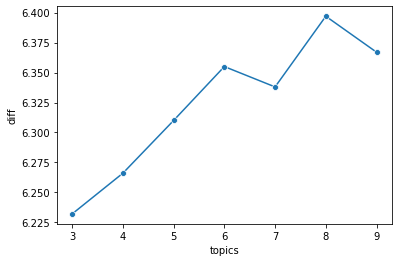

In [ ]:
import seaborn as sns
        
df_fit['diff'] = abs(df_fit.coherence - df_fit.perplexity)
sns.lineplot(x='topics', y='diff', data=df_fit, ci=None, marker='o');

**Topic Scores**

Each of the texts are given a score based on how well they fit each topic.

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                              id2word=id2word, 
                                              num_topics=8, 
                                              random_state=1,
                                              chunksize=100, 
                                              passes=5,
                                              per_word_topics=True)

#NOTICE THE ABOVE CODE IS SLIGHTLY DIFFERENT FROM YOUR BOOK

df_topics = df_tweets.copy()
        
num_topics = len(lda_model.get_topics()) # store the number of topics from the last model
for col in range(num_topics): # generate a new column for each topic
    df_topics[f'topic_{col + 1}'] = 0.0
          
        # Store the topic score and dominant topic
for i, words in enumerate(data_ready):
    doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words
          
    for j, score in enumerate(doc[0]): # for each document in the corpus
            # Get the topic score and store it in the appropriate column
        df_topics.iat[i, (len(df_topics.columns) - ((num_topics) - score[0]))] = score[1]
        
df_topics.head()
        

,Gender,Weekday,Hour,Day,Reach,RetweetCount,Klout,Sentiment,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,Male,Monday,23,2,4037,1,52,3.0,Amazon Web Services is becoming a nice predict...,0.0,0.0,0.506514,0.0,0.00000,0.0,0.052415,0.416894
1,Unknown,Friday,12,4,524418,21,72,0.0,Announcing four new VPN features in our Sao Pa...,0.0,0.0,0.961801,0.0,0.00000,0.0,0.000000,0.000000
2,Unknown,Tuesday,9,31,1748,1,46,0.0,Are you an @awscloud user? Use #Zadara + #AWS ...,0.0,0.0,0.813662,0.0,0.14841,0.0,0.000000,0.000000
3,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC...,0.0,0.0,0.956238,0.0,0.00000,0.0,0.000000,0.000000
4,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC...,0.0,0.0,0.956238,0.0,0.00000,0.0,0.000000,0.000000


*What sentences specific represent well each topic?* This is important, because this gives us an idea of what each topic includes. A good practice would be to give each topic a specific name that represents well the idea, emotion, or sentiment each topic represents.

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100
        
        # Create the output DataFrame
df_representative_tweets = pd.DataFrame(columns=df_topics.columns)
        
        # Iterate through each topic
for n in range(1, num_topics + 1):
          # Copy the row from the original df with the highest topic score into the new df
    df_representative_tweets.loc['topic_' + str(n)] = df_topics.loc[df_topics['topic_' + str(n)].idxmax()]
        
df_representative_tweets

,Gender,Weekday,Hour,Day,Reach,RetweetCount,Klout,Sentiment,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
topic_1,Male,Thursday,17,18,863,3,45,0.0,"""Don't Fear #AWS Channel Checks Indicate Nothing's Changed\rhttp://www.benzinga.com/analyst-rati...",0.963502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_2,Unknown,Tuesday,11,12,2509,1,56,2.0,awscloud: AWS #IoT now supports using your own certificates! https://aws.amazon.com/about-aws/wh...,0.000000,0.937437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_3,Unknown,Tuesday,14,26,472131,28,71,2.0,AWS Mobile Hub now supports Google+ Sign-in. https://aws.amazon.com/about-aws/whats-new/2016/01/...,0.000000,0.000000,0.970811,0.000000,0.000000,0.000000,0.000000,0.000000
topic_4,Unknown,Tuesday,15,26,592479,34,74,0.0,Now upgrade existing Amazon RDS MySQL database instances to @MySQL version 5.7.11! https://aws.a...,0.100268,0.000000,0.000000,0.868437,0.000000,0.000000,0.000000,0.000000
topic_5,Unknown,Sunday,3,17,100,1,43,0.0,Cloud Pricing Limbo: How Low Can Azure Google and AWS Go?: In the latest edition of cloud pricin...,0.000000,0.000000,0.000000,0.000000,0.912858,0.000000,0.058265,0.000000
topic_6,Unknown,Friday,1,13,616904,7,74,2.0,The first #AWSSummit arrives in Madrid on June 2nd. Now is your last chance to register! https:/...,0.000000,0.068190,0.059698,0.000000,0.000000,0.754294,0.000000,0.088322
topic_7,Unknown,Wednesday,0,22,1570,1,47,0.0,#LiverpoolJobs AWS Technical Specialist - Email Integration Cloud Migration: Gibbs S3 - Liv... h...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.964979,0.000000
topic_8,Unknown,Thursday,12,24,2362,1,56,2.0,awscloud: Make #BigData your most powerful asset with AWS &amp; APN Partners: https://aws.amazon...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.958272


**Visualizations** help us understand a little more concerning words/phrases specifically associated with each topic and which ones specifically stand out.

<Figure size 1296x504 with 0 Axes>

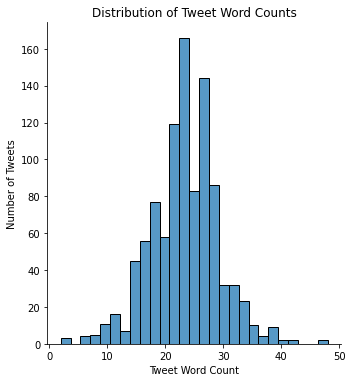

In [ ]:
doc_lens = [len(d) for d in data_ready]

plt.figure(figsize=(18,7))
sns.displot(doc_lens, bins=27)
plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

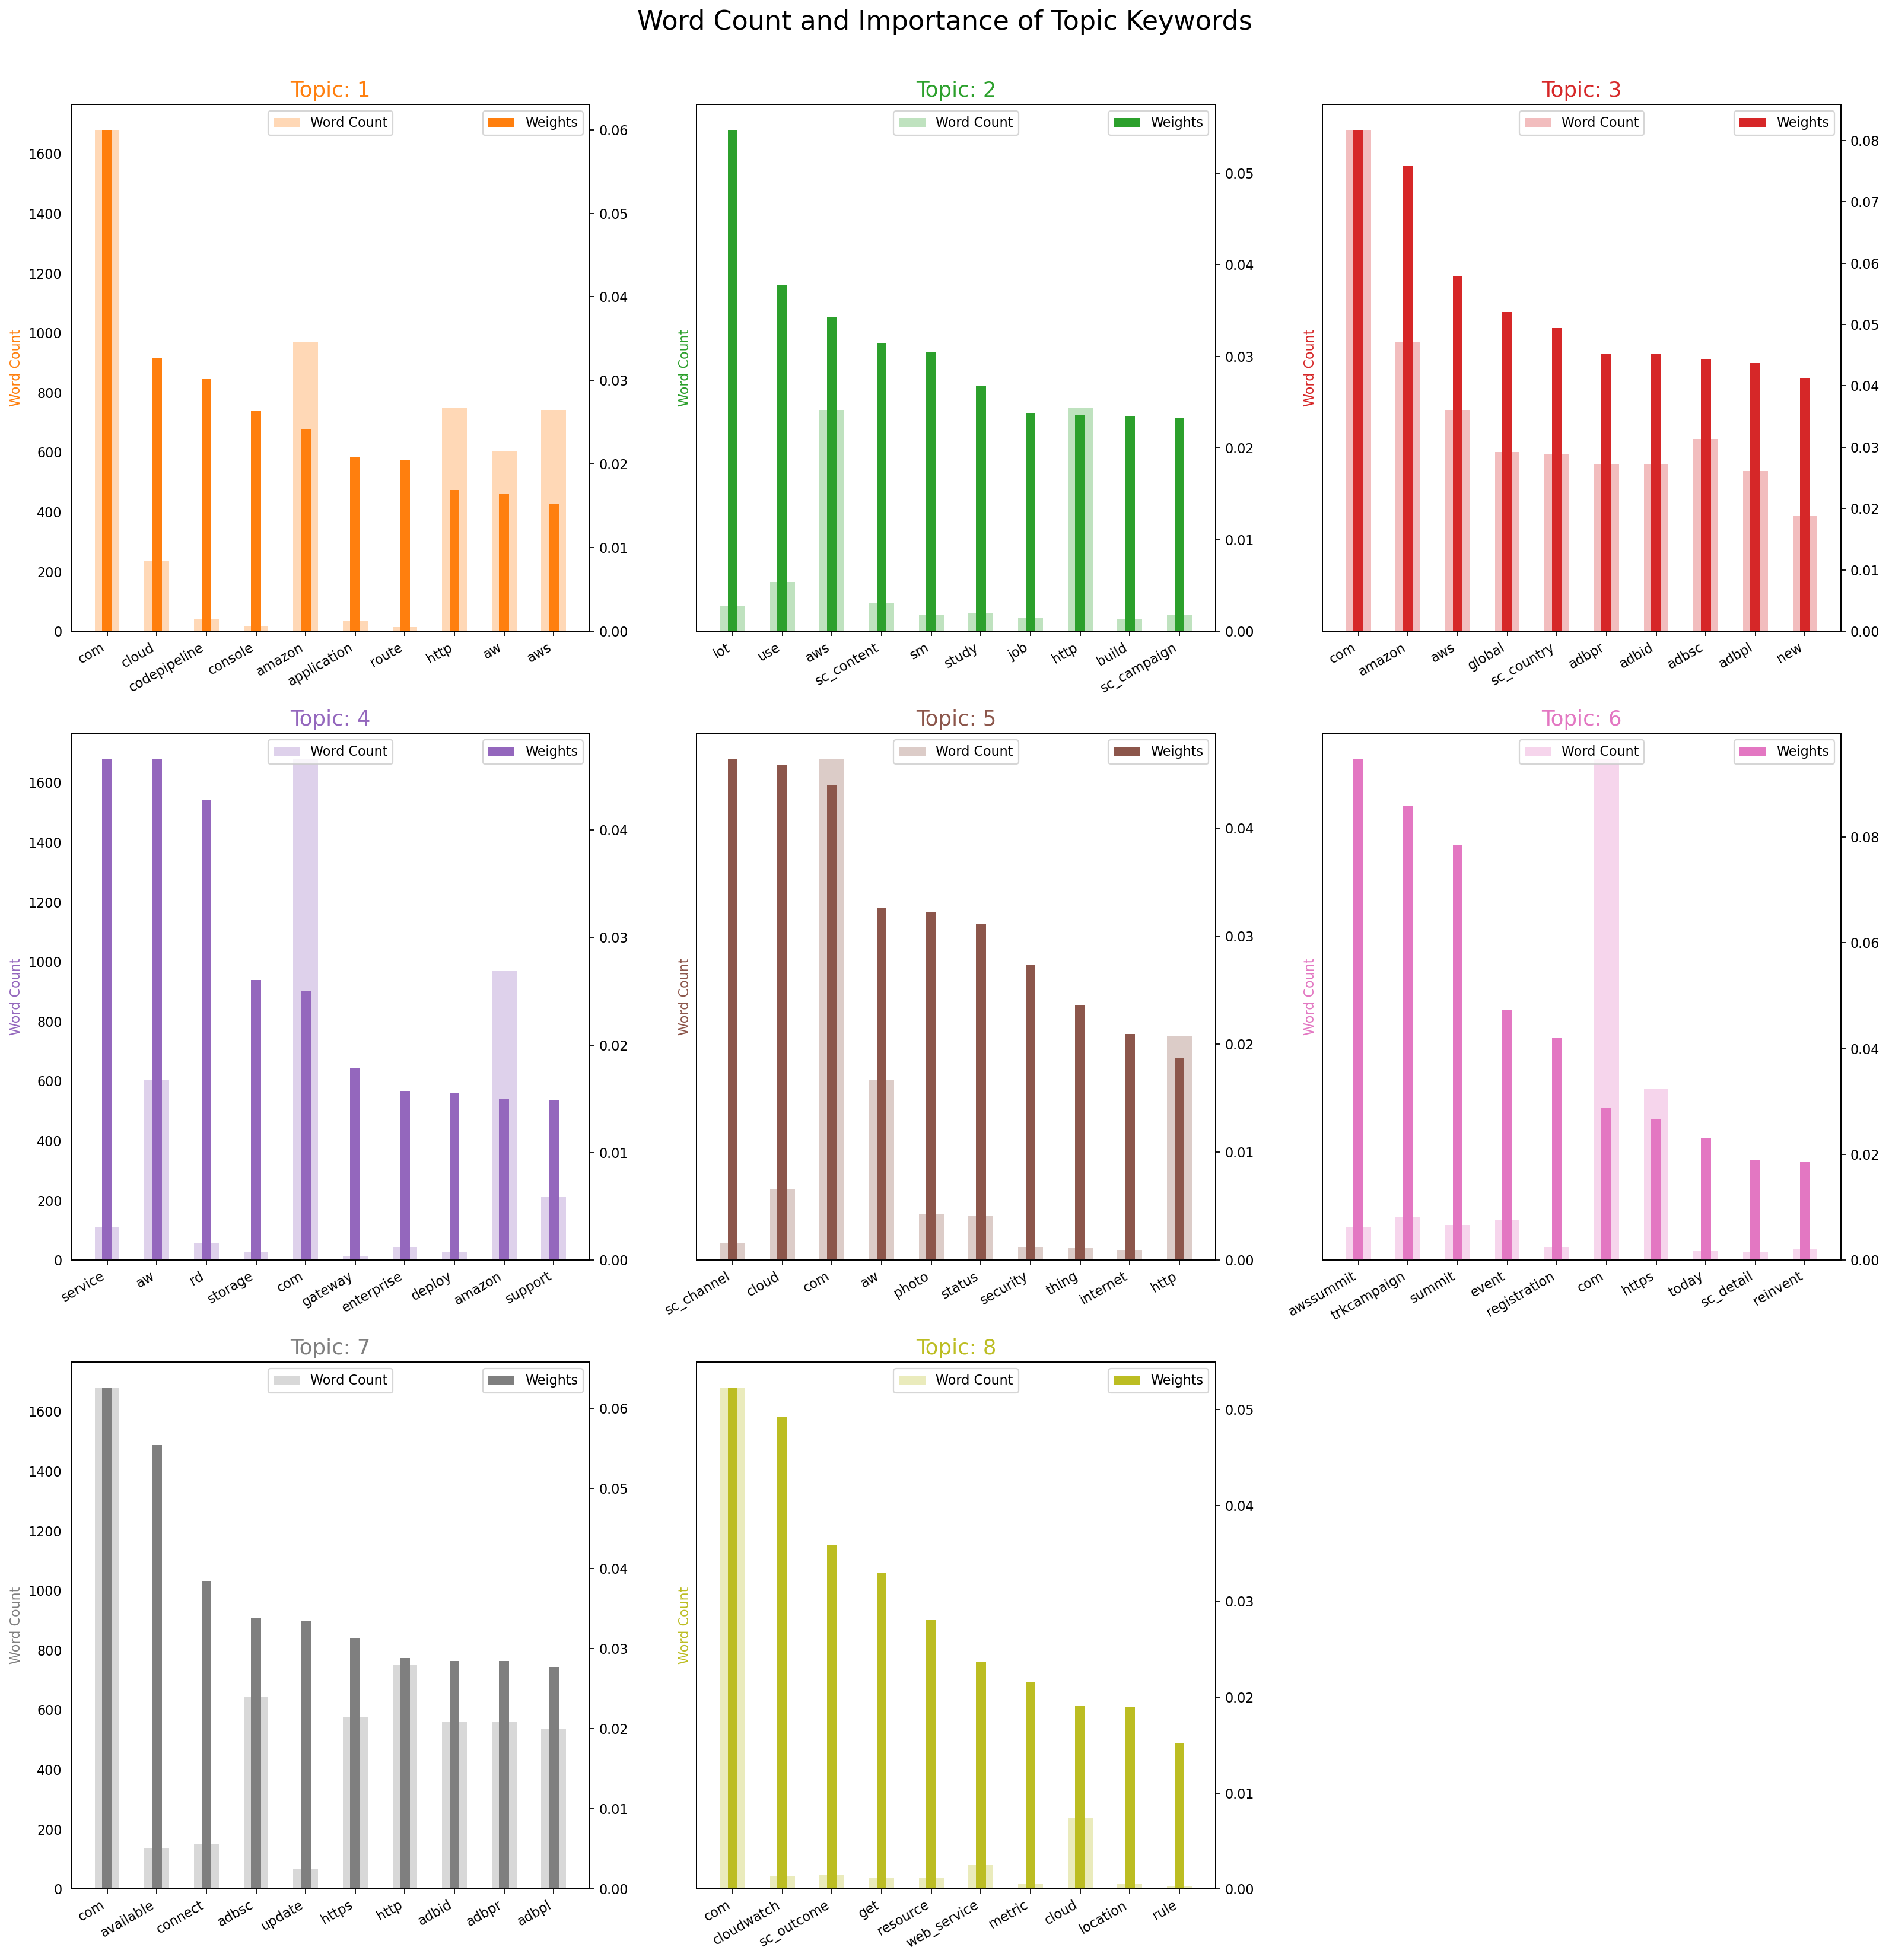

In [ ]:
# Bar chart of word counts for each topic
from collections import Counter
import matplotlib.colors as mcolors, math

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
  for word, weight in topic:
    out.append([word, i + 1, weight, counter[word]])

df_temp = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
matrix_size = math.ceil(num_topics**(1/2))  # Computes the n by n number of plots to generate
fig, axes = plt.subplots(matrix_size, matrix_size, figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
  ax.bar(x='word', height="word_count", data=df_temp.loc[df_temp.topic_id==i+1, :], color=cols[i+1], width=0.5, alpha=0.3, label='Word Count')
  ax_twin = ax.twinx()
  ax_twin.bar(x='word', height="importance", data=df_temp.loc[df_temp.topic_id==i+1, :], color=cols[i+1], width=0.2, label='Weights')
  ax.set_ylabel('Word Count', color=cols[i+1])
  ax.set_title('Topic: ' + str(i + 1), color=cols[i+1], fontsize=16)
  ax.tick_params(axis='y', left=False)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(df_temp.loc[df_temp.topic_id==i+1, 'word'], rotation=30, horizontalalignment= 'right')
  ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')
  if i >= len(topics): # Turn off the unneeded subplots
    ax.axis('off')
    ax.title.set_visible(False)
    ax_twin.axis('off')
    ax.legend().set_visible(False)
    ax_twin.legend().set_visible(False)

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.03)
plt.show()

**Regression Analysis** can help us understand which particular topics have an influence on the number of retweets.

**ACTIVITY:** Go through the multiple linear regression progress to see which topics have the most influence. Try to give names to each of these topics as well.

In [ ]:
import statsmodels.api as sm

df_dummies = pd.get_dummies(df_topics, columns=['Gender', 'Weekday'], drop_first=True)

y = df_dummies.RetweetCount
X = df_dummies.drop(columns=['RetweetCount', 'Reach', 'text'])
    
results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           RetweetCount   R-squared (uncentered):                   0.494
Model:                            OLS   Adj. R-squared (uncentered):              0.483
Method:                 Least Squares   F-statistic:                              45.54
Date:                Mon, 31 Mar 2025   Prob (F-statistic):                   5.89e-129
Time:                        16:28:01   Log-Likelihood:                         -4338.4
No. Observations:                1000   AIC:                                      8719.
Df Residuals:                     979   BIC:                                      8822.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------